In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Parameters
sampling_rate = 4000
effective_tunnels = (6, )

In [17]:
# Load Sensor-output Data
displacement = np.loadtxt('data/A2-2.txt', skiprows=1, usecols=effective_tunnels)
print(displacement[0:10])

[720.104004 719.672791 718.143982 724.768799 727.120789 736.842407
 743.036011 749.660767 764.04718  768.084778]


In [18]:
# time_axis = np.arange(0, displacement.shape[0])
time_axis = np.arange(0, 400)
time_axis = time_axis / sampling_rate

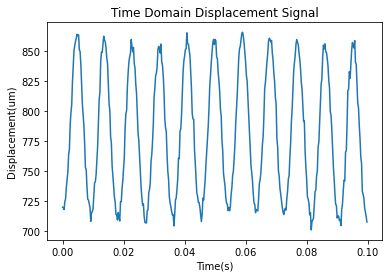

In [19]:
# Time Domain Signal Diagram
plt.figure()

plt.plot(time_axis, displacement[0:400])
plt.title(u'Time Domain Displacement Signal')
plt.xlabel('Time(s)')
plt.ylabel('Displacement(um)')

plt.show()

In [20]:
# Filter

In [21]:
# FFT
import scipy.fftpack as fftpack

displayed_max_freq = 200
assert displayed_max_freq > 0 and displayed_max_freq < (sampling_rate // 2)

freq_spectrum = fftpack.fft(displacement)

freq_axis = fftpack.fftfreq(displacement.size, d=1/sampling_rate)
# freq_axis = fftpack.fftshift(freq_axis)
print(freq_axis[0:10])

freq_spectrum_magnitude = np.sqrt(np.real(freq_spectrum)**2 + np.imag(freq_spectrum)**2)

[0.         0.03693785 0.0738757  0.11081356 0.14775141 0.18468926
 0.22162711 0.25856496 0.29550282 0.33244067]


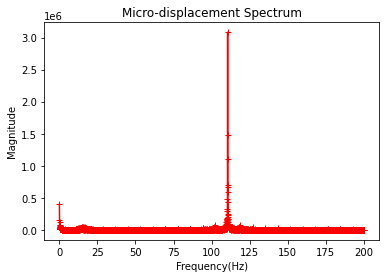

In [22]:
# Spetrum Plotting
plt.figure()

sampling_num = displacement.size * displayed_max_freq // sampling_rate
plt.plot(freq_axis[1:sampling_num], freq_spectrum_magnitude[1:sampling_num], 'r+-')
plt.title(u'Micro-displacement Spectrum')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Magnitude')

plt.show()

In [23]:
# Measurement Results
dominant_freq = freq_axis[np.argmax(freq_spectrum_magnitude[1:])]
print('Dominant Frequency(Hz): %.2f' % dominant_freq)

Dominant Frequency(Hz): 110.48


In [ ]:
# Similarity Analysis